## Environment setup

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image

# Device configuration
print(f"PyTorch version: {torch.__version__}", end="\t")
print("GPU found" if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 1.10.1+cu113	GPU found :)


## Data loading

In [2]:
sample_dir = "samples"

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
image_dir = "./data/archive/Abstract_gallery/Abstract_gallery"
class_image_dir = "./data/archive/Abstract_gallery/"

In [4]:
print(f"Nombre d'image: {len(os.listdir(image_dir))}")

Nombre d'image: 2782


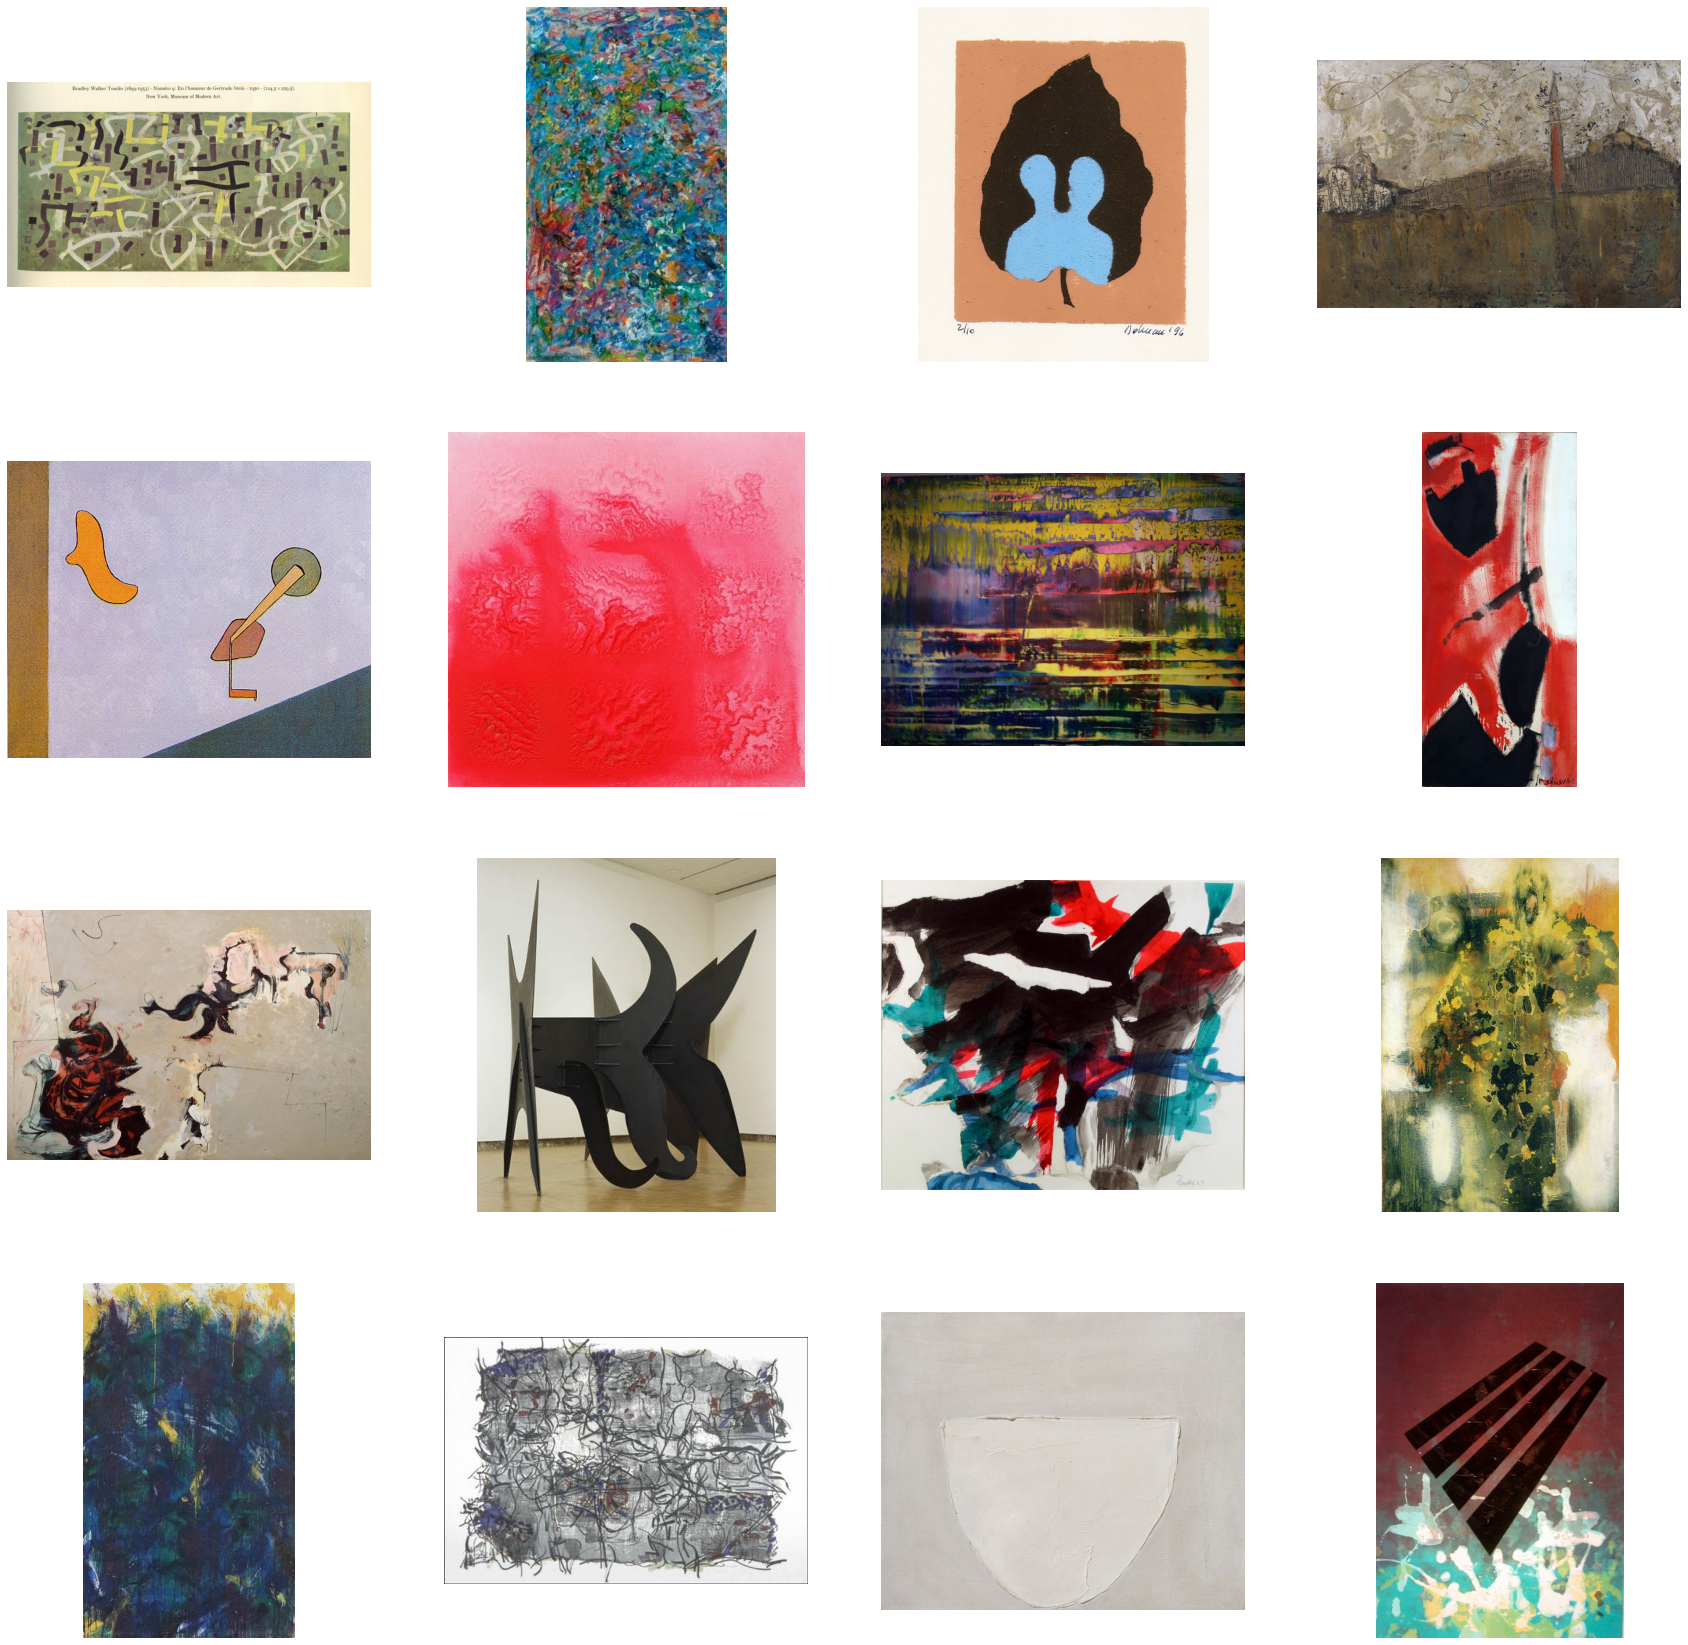

In [86]:
fig = plt.figure(figsize=(30, 30))
for image_index in range(16):
    plt.subplot(4, 4, 1 + image_index)
    img = plt.imread(os.path.join(image_dir, np.random.choice(os.listdir(image_dir))))
    plt.imshow(img)
    plt.axis("off")

In [6]:
batch_size = 16
image_size = 256
nb_channel = 3

transf = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

img_dataset = datasets.ImageFolder(class_image_dir, transform=transf)
dataloader = DataLoader(img_dataset, batch_size=batch_size, shuffle=True)

#### Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


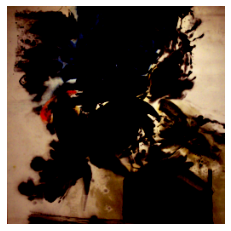

In [9]:
batch = next(iter(dataloader))
img = batch[0][0]
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

## Model definition

In [10]:
# Hyper-parameters
hidden_size = 64
latent_size = 200

# Generator
G = nn.Sequential(
    nn.ConvTranspose2d(
        in_channels=latent_size,
        out_channels=hidden_size * 16,
        kernel_size=8,
        stride=1,
        padding=0,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size * 16),
    nn.ReLU(True),
    # output: hidden_size*8 x 8 x 8
    nn.ConvTranspose2d(
        in_channels=hidden_size * 16,
        out_channels=hidden_size * 8,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size * 8),
    nn.ReLU(True),
    # output: hidden_size*4 x 16 x 16
    nn.ConvTranspose2d(
        in_channels=hidden_size * 8,
        out_channels=hidden_size * 4,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size * 4),
    nn.ReLU(True),
    # output: hidden_size*4 x 16 x 16
    nn.ConvTranspose2d(
        in_channels=hidden_size * 4,
        out_channels=hidden_size * 2,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size * 2),
    nn.ReLU(True),
    # output: hidden_size*2 x 32 x 32
    nn.ConvTranspose2d(
        in_channels=hidden_size * 2,
        out_channels=hidden_size,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size),
    nn.ReLU(True),
    # output: hidden_size*2 x 64 x 64
    nn.ConvTranspose2d(
        in_channels=hidden_size,
        out_channels=nb_channel,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.Tanh(),
    # output: 3 x 128 x 128
)

G = G.to(device)

lat = torch.randn(batch_size, latent_size, 1, 1, device=device)
print(lat.shape)
outG = G(lat)
print(outG.shape)

torch.Size([16, 200, 1, 1])
torch.Size([16, 3, 256, 256])


In [11]:
# Discriminator
D = nn.Sequential(
    nn.Conv2d(
        in_channels=nb_channel,
        out_channels=hidden_size,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size),
    nn.LeakyReLU(0.2, inplace=True),
    # output: hidden_size, 64, 64
    nn.Conv2d(
        in_channels=hidden_size,
        out_channels=hidden_size * 2,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # output: hidden_size*2, 32, 32
    nn.Conv2d(
        in_channels=hidden_size * 2,
        out_channels=hidden_size * 4,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # output: hidden_size*4, 16, 16
    nn.Conv2d(
        in_channels=hidden_size * 4,
        out_channels=hidden_size * 8,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # output: hidden_size*8, 8, 8
    nn.Conv2d(
        in_channels=hidden_size * 8,
        out_channels=hidden_size * 16,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(hidden_size * 16),
    nn.LeakyReLU(0.2, inplace=True),
    # output: hidden_size*4, 16, 16
    nn.Conv2d(
        in_channels=hidden_size * 16,
        out_channels=1,
        kernel_size=8,
        stride=1,
        padding=0,
        bias=False,
    ),
    nn.Sigmoid()
    # output: 1, 1, 1
)

D = D.to(device)

data = batch[0].to(device)
print(data.shape)
outD = D(data)
print(outD.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 1, 1])


In [12]:
print(G)

Sequential(
  (0): ConvTranspose2d(200, 1024, kernel_size=(8, 8), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [13]:
print(D)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

## Loss, optimizer and utilities

In [14]:
import torch.optim as optim

lr = 2e-4

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
def denorm(x):
    """Denormalize an image tensor"""
    out = (x + 1) / 2
    return out.clamp(0, 1)


def reset_grad():
    """Reset gradients for both optimizers"""
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Model training

In [16]:
num_epochs = 200
step_count = len(dataloader)

reset_grad()
fake_scores = []
real_scores = []
d_losses = []
g_losses = []

# Start training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):

        # Create the labels which are later used as input for the BCE loss
        b_size = images.shape[0]
        real_labels = torch.ones(b_size).to(device)
        fake_labels = torch.zeros(b_size).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        D.zero_grad()
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since y == real_labels == 1
        images = images.to(device)
        real_outputs = D(images).view(-1)
        d_loss_real = criterion(real_outputs, real_labels)
        real_score = real_outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since y == fake_labels == 0
        noise = torch.randn(b_size, latent_size, 1, 1).to(device)
        fake_images = G(noise)

        fake_outputs = D(fake_images.detach()).view(-1)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        fake_score = fake_outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_loss_real.backward()
        d_loss_fake.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        G.zero_grad()
        # Compute loss with fake images
        outputs = D(fake_images).view(-1)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        g_loss.backward()
        g_optimizer.step()

    print(
        f"Epoch [{epoch + 1}/{num_epochs}]"
        # f", Step [{i + 1}/{step_count}]"
        f", d_loss: {d_loss.item():.4f}"
        f", g_loss: {g_loss.item():.4f}"
        f", D(x): {real_score.mean().item():.2f}"
        f", D(G(z)): {fake_score.mean().item():.2f}"
    )

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    real_scores.append(real_score.mean().item())
    fake_scores.append(fake_score.mean().item())

    # Save real images
    if (epoch + 1) == 1:
        images = images.reshape(images.size(0), nb_channel, image_size, image_size)
        save_image(denorm(images), os.path.join(sample_dir, "real_images_art.png"))

    # Save sampled images
    if (epoch + 1) % 10 == 0:
        fake_images = fake_images.reshape(
            fake_images.size(0), nb_channel, image_size, image_size
        )
        save_image(
            denorm(fake_images),
            os.path.join(sample_dir, f"fake_images_art-{epoch + 1}.png"),
        )

Epoch [1/200], d_loss: 0.2280, g_loss: 5.3569, D(x): 0.84, D(G(z)): 0.02
Epoch [2/200], d_loss: 1.7020, g_loss: 4.0229, D(x): 0.57, D(G(z)): 0.42
Epoch [3/200], d_loss: 0.3906, g_loss: 2.5076, D(x): 0.86, D(G(z)): 0.18
Epoch [4/200], d_loss: 1.1732, g_loss: 1.7184, D(x): 0.66, D(G(z)): 0.32
Epoch [5/200], d_loss: 1.1463, g_loss: 4.8471, D(x): 0.78, D(G(z)): 0.51
Epoch [6/200], d_loss: 1.3282, g_loss: 0.7343, D(x): 0.56, D(G(z)): 0.40
Epoch [7/200], d_loss: 1.8134, g_loss: 4.8163, D(x): 0.96, D(G(z)): 0.78
Epoch [8/200], d_loss: 2.1332, g_loss: 5.7190, D(x): 0.69, D(G(z)): 0.69
Epoch [9/200], d_loss: 1.0725, g_loss: 2.3149, D(x): 0.55, D(G(z)): 0.05
Epoch [10/200], d_loss: 1.7199, g_loss: 8.2426, D(x): 0.98, D(G(z)): 0.75
Epoch [11/200], d_loss: 0.7940, g_loss: 3.1508, D(x): 0.63, D(G(z)): 0.12
Epoch [12/200], d_loss: 1.8140, g_loss: 9.5218, D(x): 0.79, D(G(z)): 0.74
Epoch [13/200], d_loss: 0.7223, g_loss: 4.0204, D(x): 0.87, D(G(z)): 0.39
Epoch [14/200], d_loss: 1.1573, g_loss: 5.0543,

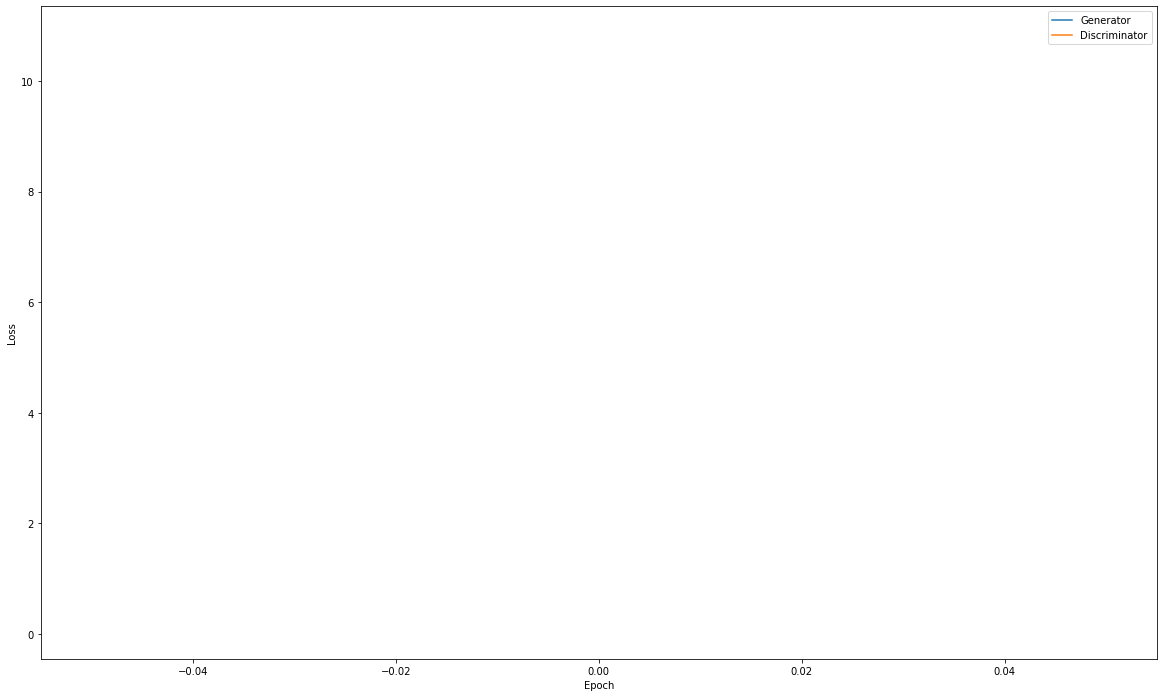

In [70]:
plt.figure(figsize=(20, 12))
plt.plot(g_losses.detach().cpu().numpy(), label="Generator")
plt.plot(d_losses.detach().cpu().numpy(), label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [87]:
plt.figure(figsize=(20, 12))
plt.plot(real_scores.cpu().numpy(), label="Real images")
plt.plot(fake_scores.cpu().numpy(), label="Fake images")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

NameError: name 'real_scores' is not defined

<Figure size 1440x864 with 0 Axes>

## Save models

In [17]:
torch.save(D, "model/discriminator.pt")
torch.save(G, "model/generator.pt")

## Generate new art images

In [89]:
G_load = torch.load("model/generator.pt")
G_load.eval()

Sequential(
  (0): ConvTranspose2d(200, 1024, kernel_size=(8, 8), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [76]:
def plot_image(image):
    image = denorm(image).permute(1, 2, 0)
    img_tensor = image.cpu().numpy() if torch.cuda.is_available() else image.numpy()
    plt.imshow(img_tensor.squeeze(), cmap="binary")
    plt.axis("off")


def show_images(images, n_images=batch_size):
    plt.figure(figsize=(30, 30))
    for image_index in range(min(n_images, 96)):
        plt.subplot(4, 4, 1 + image_index)
        plot_image(images[image_index])

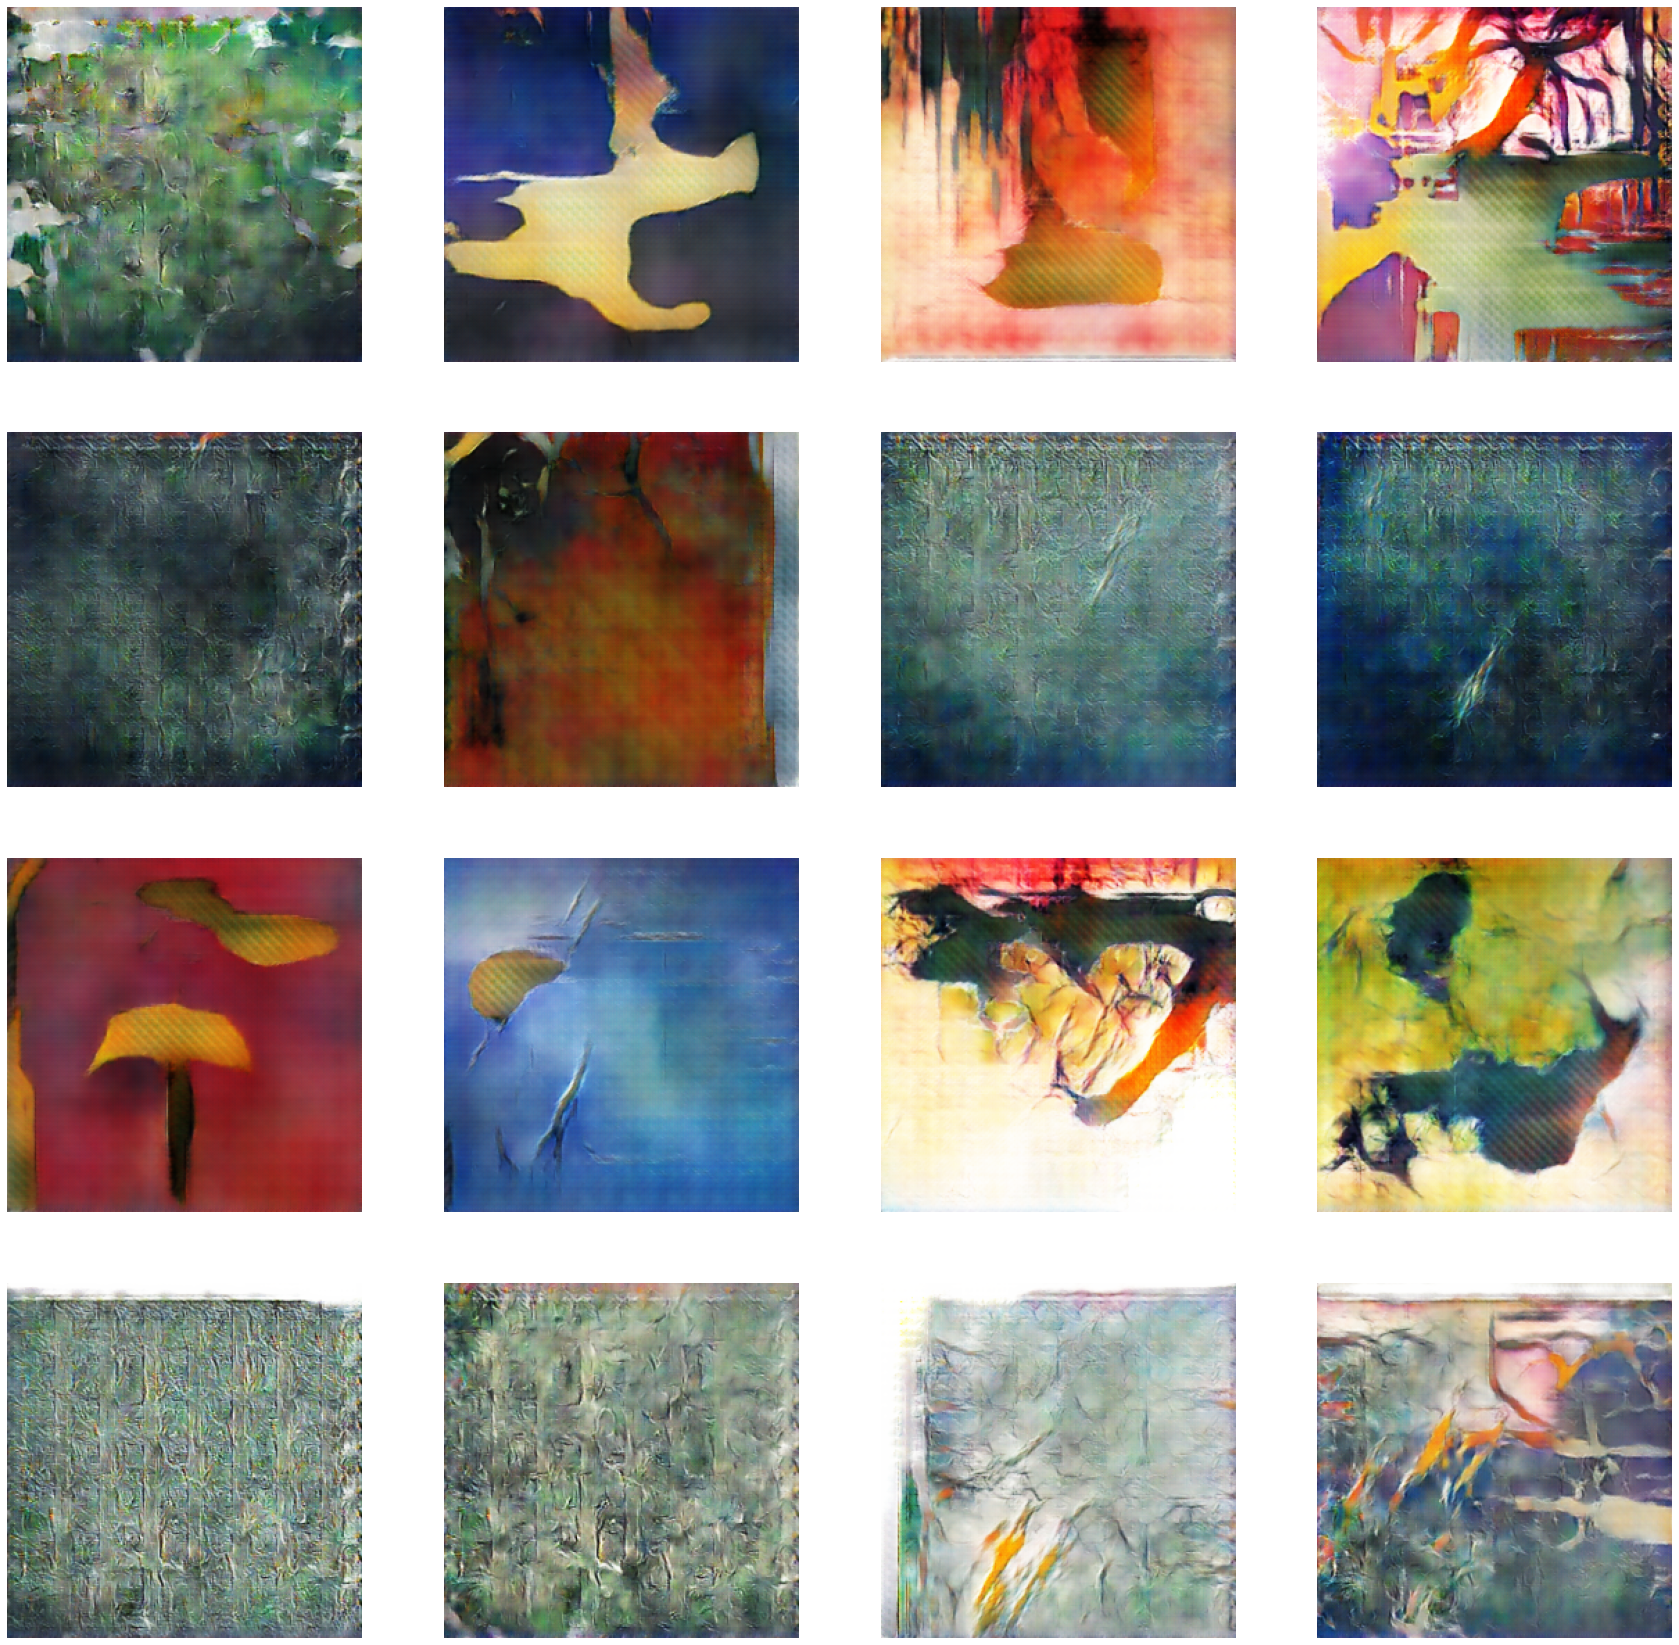

In [90]:
noise = torch.randn(batch_size, latent_size, 1, 1).to(device)

with torch.no_grad():
    fake_images = G_load(noise)
    show_images(fake_images)